In [12]:
%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#
print("Loaded Libraries")

Loaded Libraries


In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#
plt.rcParams['figure.figsize'] = (3, 3)
plt.style.use('seaborn-pastel')
plt.rcParams['figure.dpi'] = 150      
#
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]
#
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#

In [14]:
def points_plot(ax, Xtr, Xte, ytr, yte, 
                clf, 
                mesh = True, colorscale = cmap_light, cdiscrete = cmap_bold, 
                alpha = 0.1, psize = 10, 
                zfunc = False, predicted = False):
#
# note: this function only works for X.shape = (:, 2)
# it is intended to illustrate the classifier boundary
#
# get the column names if they exist to apply
# to the meshed data generated below
#
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#
    h = 0.02
#
# create a uniform grid spanning the range of the X values
# note that y here is NOT the target, it is the 2nd
# dimension of the desired plot
#
    X = np.concatenate((Xtrain, Xtest))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
#
# predict the target value at each point in the grid
#
# this method uses the probabilities from the classifier
# and applies a function to determine the class
#
    if zfunc:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                         columns = feature_names)
        p0 = clf.predict_proba(mesh_data)[:, 0]
        p1 = clf.predict_proba(mesh_data)[:, 1]
        Z = zfunc(p0, p1)
#
# this method uses the classifier to predict the classes directly
#
    else:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                                     columns = feature_names)
        Z = clf.predict(mesh_data)
    ZZ = Z.reshape(xx.shape)
# plt.pcolormesh() creates a shaded result over the grid
#
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, 
                       cmap = cmap_light, 
                       alpha = alpha, 
                       axes = ax, 
                       shading = 'auto')
#
# add the points to the plot
# these can be the original target values
# or the predicted values
#
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
#
# plot training points
#
    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], 
               c = showtr - 1, 
               cmap = cmap_bold, 
               s = psize, 
               alpha = alpha, 
               edgecolor = "k")
#    
# plot testing points
#
    ax.scatter(Xtest[:, 0], Xtest[:, 1],
               c = showte - 1, 
               cmap = cmap_bold, 
               s = psize + 10,
               alpha = alpha, 
               marker = "s")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#
    return ax, xx, yy

In [15]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, 
                     clf, colorscale = cmap_light, cdiscrete = cmap_bold, 
                     ccolor = cm, 
                     alpha = 0.1, psize = 10):
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#    
    ax, xx, yy = points_plot(ax, Xtr, Xte, ytr, yte,
                         clf,
                         mesh = False, 
                         colorscale = colorscale, cdiscrete = cdiscrete, 
                         psize = psize, alpha = alpha,
                         predicted = True) 
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    if feature_names is not None:
        mesh_data = pd.DataFrame(mesh_data, 
                     columns = feature_names)    
    Z = clf.predict_proba(mesh_data)[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap = ccolor, alpha = 0.2)
    cs2 = plt.contour(xx, yy, Z, cmap = ccolor, alpha = 0.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 12)
#
    plt.show()

## Sourcing and loading data ( heart dataset)

In [16]:
heart = pd.read_csv("heart.csv")
heart.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


## Exploring the data

In [17]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [18]:
heart["HeartDisease"].unique()

array([0, 1])

In [19]:
# Replace 1 and 0 by 'Yes' and 'No'
heart['HeartDisease'] = heart['HeartDisease'].replace(1.0, 'Yes')
heart['HeartDisease'] = heart['HeartDisease'].replace(0.0, 'No')
heart["HeartDisease"].unique()

array(['No', 'Yes'], dtype=object)

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

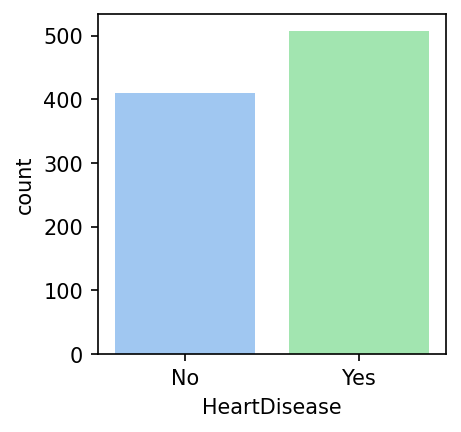

In [28]:
sns.countplot(x=heart["HeartDisease"])

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

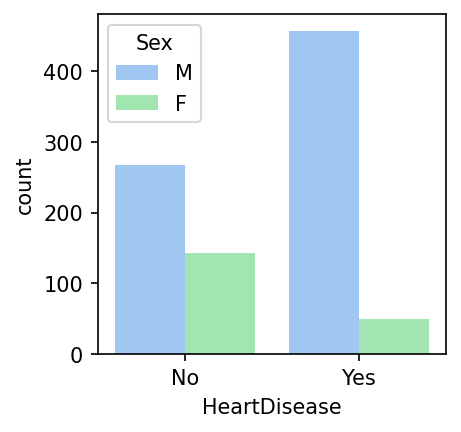

In [29]:
sns.countplot(data=heart, x="HeartDisease", hue="Sex")

Much more Male than female have heartdisease

<AxesSubplot:xlabel='HeartDisease', ylabel='Age'>

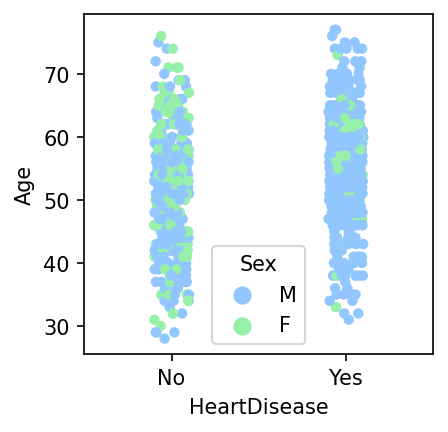

In [67]:
sns.stripplot(data=heart, x="HeartDisease", y="Age",hue="Sex")

Women who have heart disease are almost in the range of 55 to 65, while men are from 35 to 75.

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

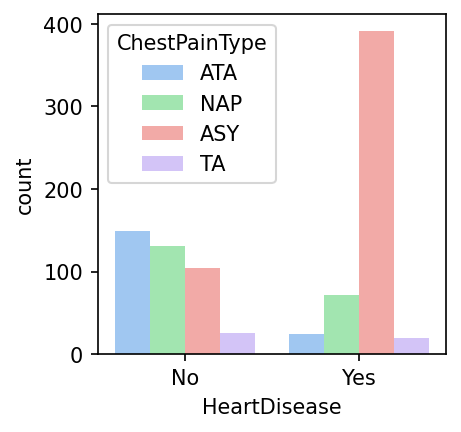

In [30]:
sns.countplot(data=heart, x="HeartDisease", hue="ChestPainType")

Much more people who have heart disease have Asymptomatic type pain.

<AxesSubplot:xlabel='HeartDisease', ylabel='Cholesterol'>

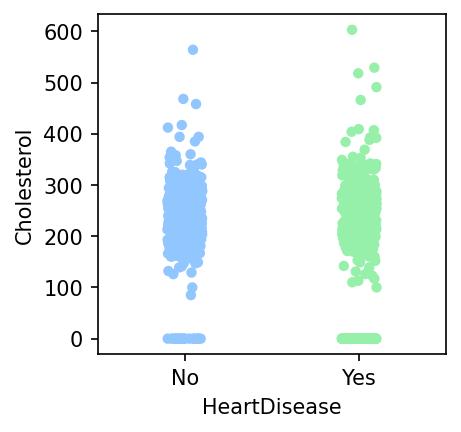

In [34]:
sns.stripplot(data=heart, x="HeartDisease", y="Cholesterol")

<AxesSubplot:xlabel='HeartDisease', ylabel='RestingBP'>

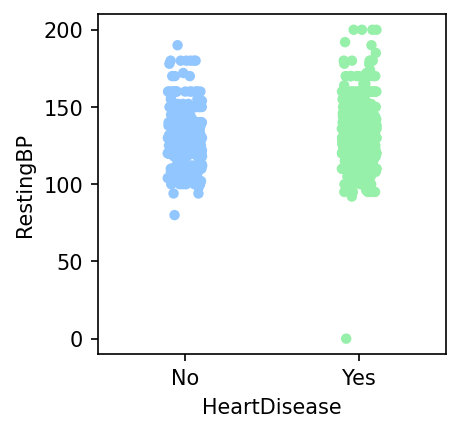

In [35]:
sns.stripplot(data=heart, x="HeartDisease", y="RestingBP")

In [36]:
heart["FastingBS"].unique()

array([0, 1])

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

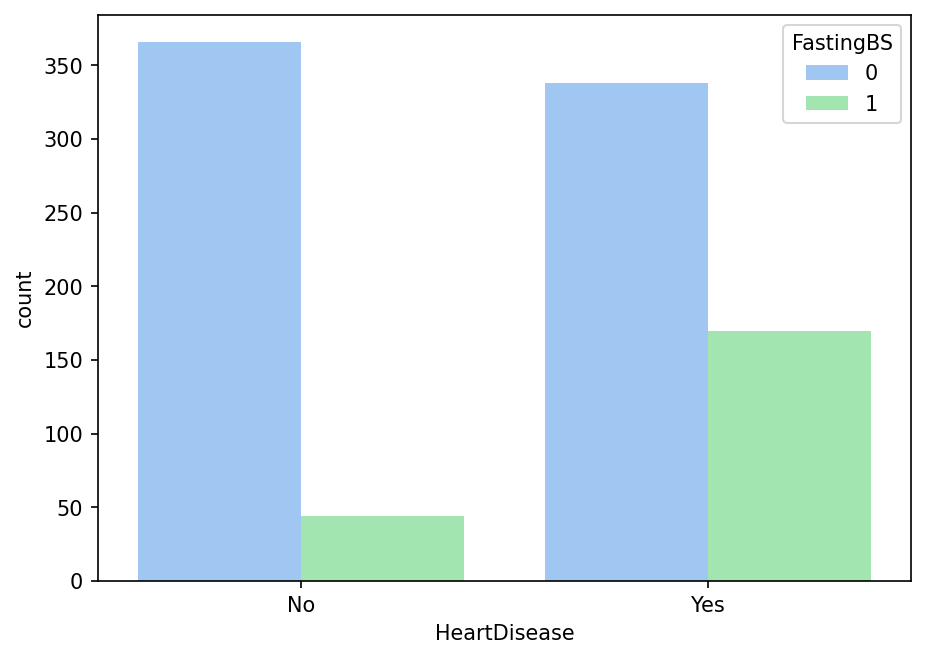

In [63]:
plt.figure(figsize=(7,5))
sns.countplot(data=heart, x="HeartDisease", hue="FastingBS")

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

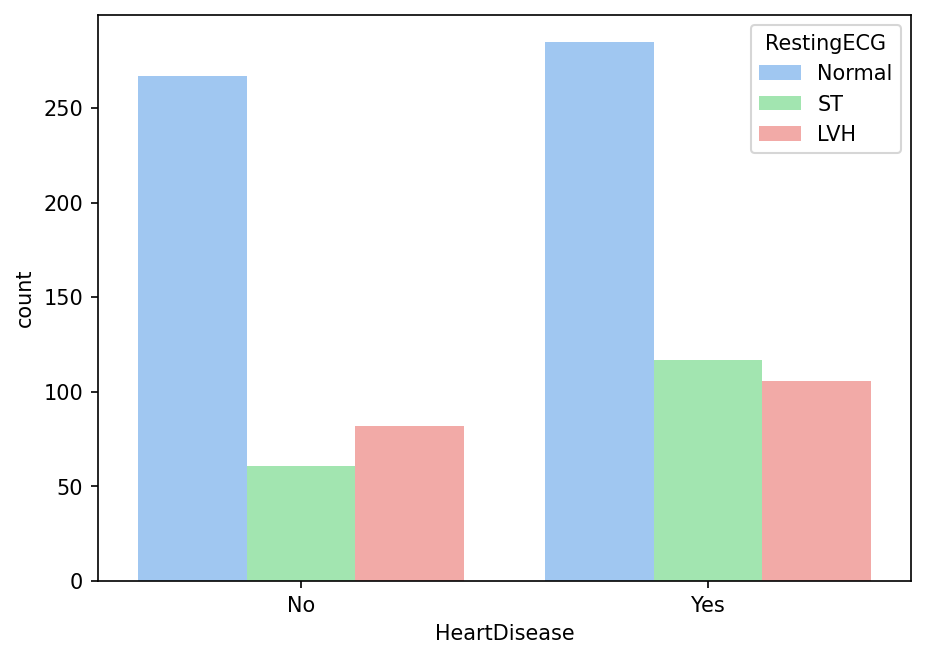

In [62]:
plt.figure(figsize=(7,5))
sns.countplot(data=heart, x="HeartDisease", hue="RestingECG")

<AxesSubplot:xlabel='HeartDisease', ylabel='MaxHR'>

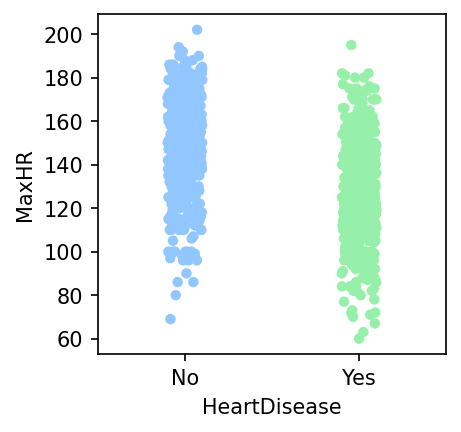

In [40]:
sns.stripplot(data=heart, x="HeartDisease", y="MaxHR")

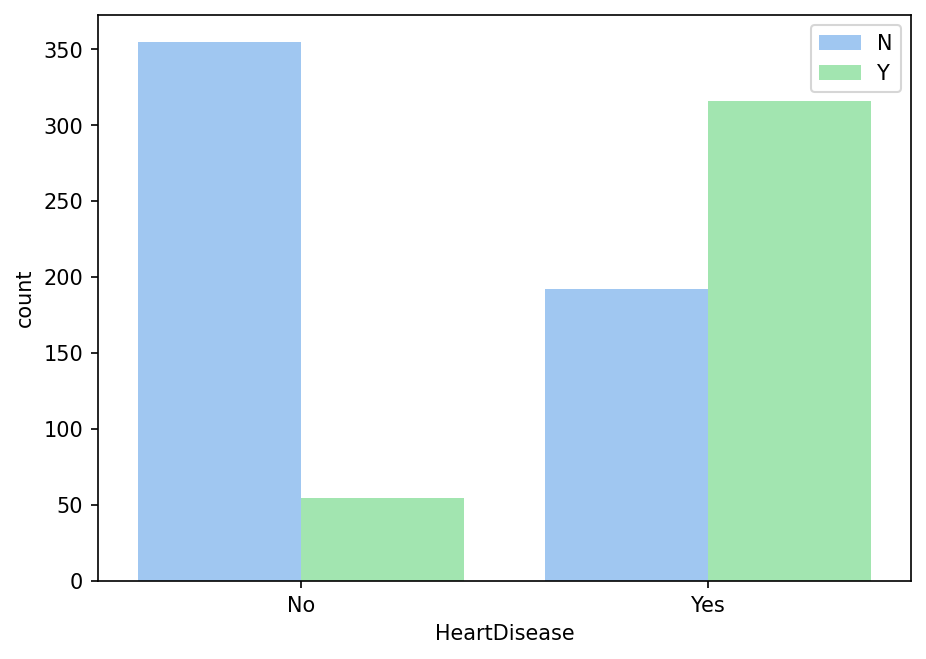

In [61]:
plt.figure(figsize=(7,5))
sns.countplot(data=heart, x="HeartDisease", hue="ExerciseAngina")
plt.legend(loc='upper right')

In [42]:
heart["Oldpeak"].unique()

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  0.5,  2.5,  5. ,  0.8,  0.7,
        1.4,  2.1,  0.4,  0.2,  1.7,  2.2,  0.1,  1.6,  1.3,  0.3,  1.8,
        2.6, -0.9,  2.8, -2.6, -1.5, -0.1,  0.9,  1.1,  2.4, -1. , -1.1,
       -0.7, -0.8,  3.7,  1.2, -0.5, -2. ,  1.9,  3.5,  0.6,  3.1,  2.3,
        3.4,  3.6,  4.2,  3.2,  5.6,  3.8,  2.9,  6.2,  4.4])

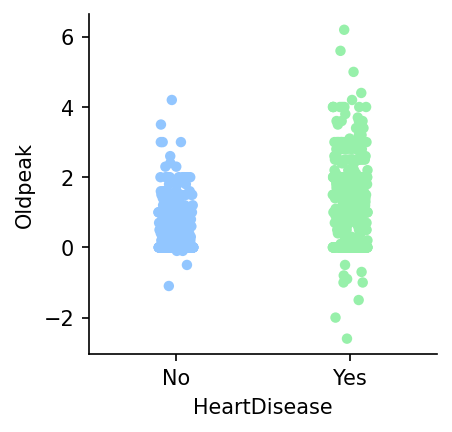

In [44]:
sns.stripplot(data=heart, x="HeartDisease", y="Oldpeak")
sns.despine()

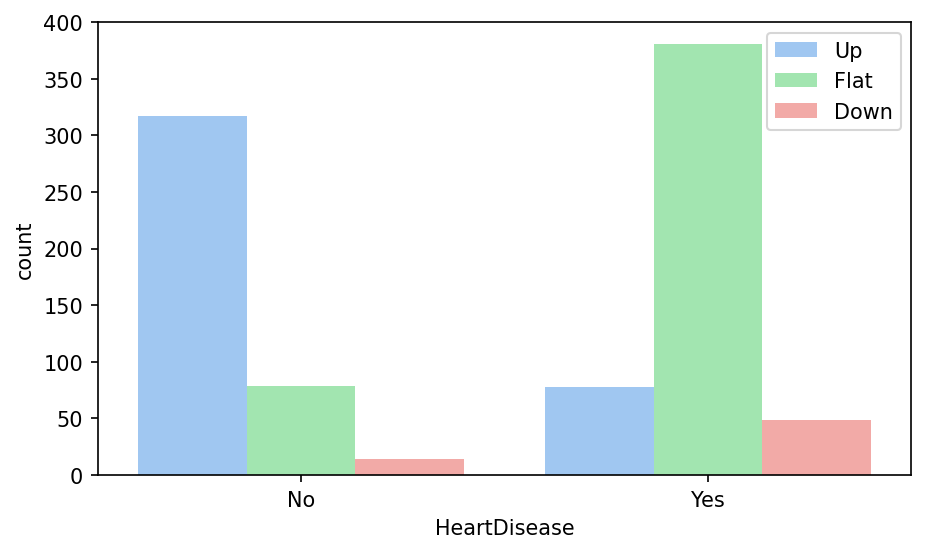

In [65]:
plt.figure(figsize=(7,4))
sns.countplot(data=heart, x="HeartDisease", hue="ST_Slope")
plt.legend(loc='upper right')